In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from model import SMT
from utils import (make_datasets, move_to_device,
                   split_sequence, calculate_metrics, windowing, plot_pred)
import random


%load_ext autoreload
%autoreload 2

## 1. Data Exploration

In [2]:
import pandas as pd

csv_input = pd.read_csv('../data/files/dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(932400, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

932400


In [5]:
# show general statistics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932400 entries, 0 to 932399
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pos.x     932400 non-null  float64
 1   pos.y     932400 non-null  float64
 2   pos.z     932400 non-null  float64
 3   heading   932400 non-null  float64
 4   velocity  932400 non-null  float64
 5   weather   932400 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 42.7 MB


col:  pos.x


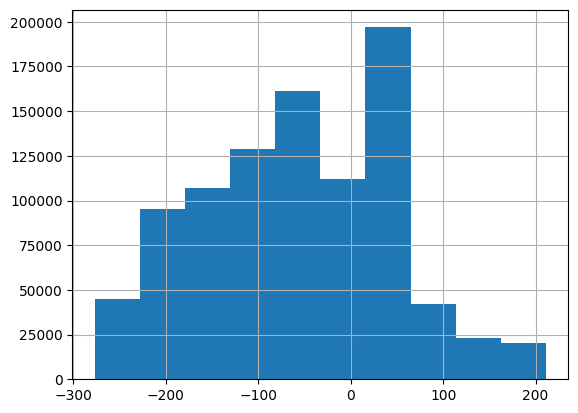

col:  pos.y


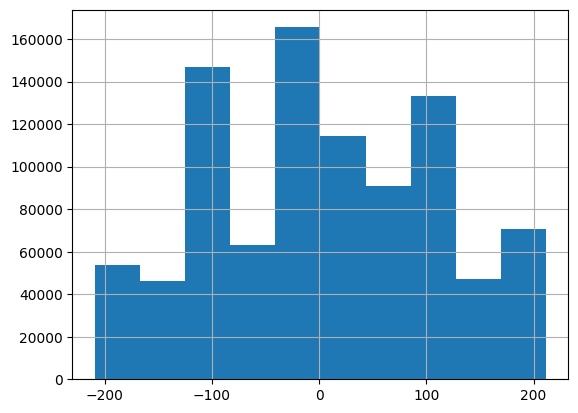

col:  pos.z


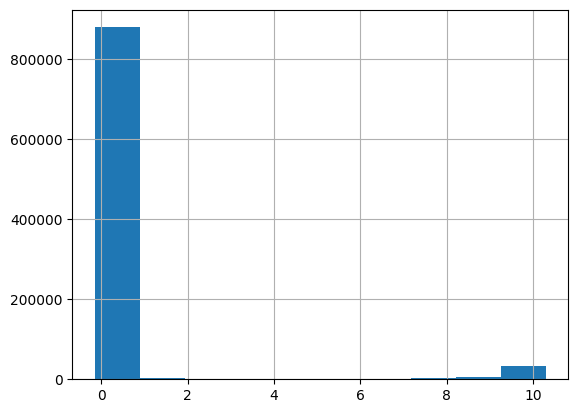

col:  heading


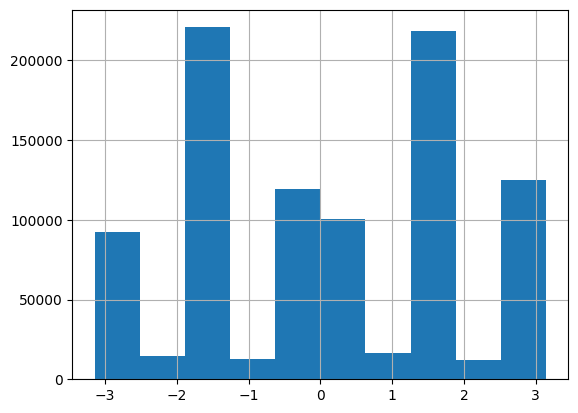

col:  velocity


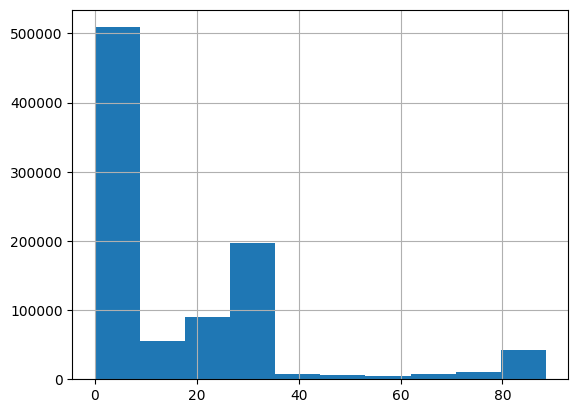

col:  weather


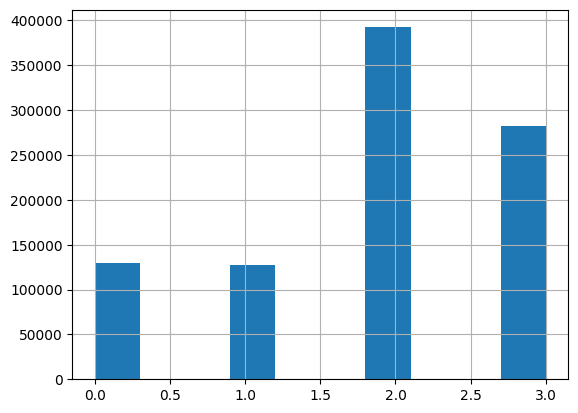

In [6]:
# Show histogram for all columns
import matplotlib.pyplot as plt
columns = data.columns
for col in columns:
    print("col: ", col)
    data[col].hist()
    plt.show()

## 2. Create windowing

In [7]:
window_size = 100
grouped_data = windowing(data, window_size)

In [8]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

9324
100
6


In [9]:
print(len(grouped_data))
print(len(grouped_data[9323]))
print(len(grouped_data[9323][0]))

9324
100
6


## 3. Model Configuration

In [10]:
BS = 512
FEATURE_DIM = 128
NUM_HEADS = 8
NUM_EPOCHS = 250
NUM_VIS_EXAMPLES = 10
NUM_LAYERS = 2
LR = 0.001
output_sequence_length = 20 # Check ratio 0.8 from utils.split_sequence() and window_size = 100 from utils.windowing() 

In [11]:
data = np.array(grouped_data) # Converting data into ndarray
type(data)
num_features = data.shape[2]
train_set, test_set = make_datasets(data)

In [12]:
train_loader, test_loader = DataLoader(
        train_set, batch_size=BS, shuffle=True
    ), DataLoader(test_set, batch_size=BS, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4. Initialize the model

In [15]:
# Initialize model, optimizer and loss criterion
model = SMT(
    num_features, num_features, FEATURE_DIM, NUM_HEADS, NUM_LAYERS, output_sequence_length
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

## 5. Train the model

In [ ]:
 # Train loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()

        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)
        src.device
        tgt.device
        # [bs, tgt_seq_len, num_features]
        pred = model(src, tgt)
        loss = criterion(pred[:, :, :2], tgt_y[:, :, :2])
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: "
        f"{(epoch_loss / len(train_loader)):.4f}"
    )

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model/model_state_dict.pth')

## 6. Evaluate the model

In [ ]:
model.eval()
eval_loss = 0.0
infer_loss = 0.0

# Variables to track the best prediction
best_loss = float('inf')
best_src = None
best_tgt = None
best_pred = None

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)

        # [bs, tgt_seq_len, num_features]
        pred = model(src, tgt)
        loss = criterion(pred[:, :, :2], tgt_y[:, :, :2])
        eval_loss += loss.item()

        # Update best prediction if current prediction is better
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_src = src
            best_tgt = tgt
            best_pred = pred

        # Run inference with model
        pred_infer = model.infer(src)
        loss_infer = criterion(pred_infer[:, :, :2], tgt_y[:, :, :2])
        infer_loss += loss_infer.item()

        # Visualize some few predictions
        #if idx < NUM_VIS_EXAMPLES:
        #    print("Feature prediction")
        #    visualize_multi_posx_posy(src, tgt, pred, pred_infer, idx)
        #    print("Trajectory prediction")
        #    visualize_multi(src[:, :, :2], tgt[:, :, :2], pred[:, :, :2], pred_infer[:, :, :2], idx)

avg_eval_loss = eval_loss / len(test_loader)
avg_infer_loss = infer_loss / len(test_loader)

print(f"Eval / Infer Loss on test set: {avg_eval_loss:.4f} / {avg_infer_loss:.4f}")

In [ ]:
print("Visualize some few predictions")

# After finding the best prediction, visualize it
if best_src is not None and best_tgt is not None and best_pred is not None:
    # This visualization will now only show the best prediction example
    for item in range(0, 10):
        index = random.randint(0, len(best_src[:, :, :2]))
        plot_pred(best_src[:, :, :2][index], best_tgt[:, :, :2][index], best_pred[:, :, :2][index])

## 7. Some metrics

In [ ]:
# Assume test_loader, model, device, criterion are defined

from utils import calculate_metrics


model.eval()
metrics_sum = {'RMSE': 0, 'MAE': 0, 'MAPE': 0}
n_batches = 0

with torch.no_grad():
    for batch in test_loader:
        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)

        pred = model(src, tgt).cpu().numpy()
        tgt_y = tgt_y.cpu().numpy()  # Convert to numpy for metric calculation

        batch_metrics = calculate_metrics(tgt_y[:, :, :2], pred[:, :, :2])
        
        # Aggregate metrics
        #for key in metrics_sum.keys():
        #    metrics_sum[key] += batch_metrics[key]
        
        #n_batches += 1

# Compute average metrics


## 8. Interpretability

In [16]:
import keras.backend as K
import numpy as np
from torch import tensor

2024-03-12 11:02:21.945119: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 11:02:22.149980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 11:02:22.150020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 11:02:22.183193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 11:02:22.256973: I tensorflow/core/platform/cpu_feature_guar

In [18]:
# loading prediction
data_path = "trained_model/model_predictions.npz"
data_prediction = np.load(data_path)

In [19]:
data_prediction

NpzFile 'trained_model/model_predictions.npz' with keys: src, tgt, pred, loss

In [ ]:
from model import TransformerWithPE
num_features = 6
model = TransformerWithPE(
    num_features, num_features, FEATURE_DIM, NUM_HEADS, NUM_LAYERS
)
model.load_state_dict(torch.load("trained_model/model_state_dict_2.pth"))

In [20]:
print(len(data_prediction["src"]))
print(len(data_prediction["tgt"]))
print(len(data_prediction["pred"]))
print(len(data_prediction["src"][0]))
print(len(data_prediction["tgt"][0]))
print(len(data_prediction["pred"][0]))
print(len(data_prediction["src"][0][0]))

512
512
512
80
20
20
6


In [21]:
num_features_pred = len(data_prediction["src"][0][0])
BS = 512
FEATURE_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 2
output_sequence_length = 20 

In [22]:
from model import SMT

model = SMT(
    num_features_pred, num_features_pred, FEATURE_DIM, NUM_HEADS, NUM_LAYERS, output_sequence_length
)
model.load_state_dict(torch.load("trained_model/model_state_dict.pth"))

<All keys matched successfully>

### Prediction Function

In [23]:
def predict_fn(src):
    y = model.infer(tensor([src]))
    return y[0].detach().numpy()
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

### Explainer

In [25]:
from model.Transformer.imt import IMT
explainer = IMT(predict_fn, rmse, data_prediction["src"][0], data_prediction["pred"][0], ["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather"])

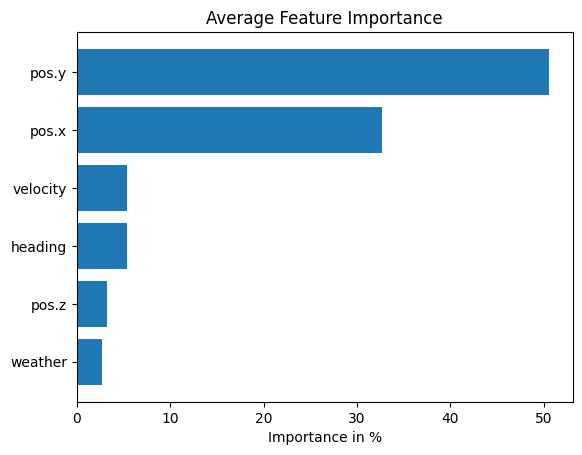

In [27]:
explainer.avg_feature_importance(data_prediction["src"][0])

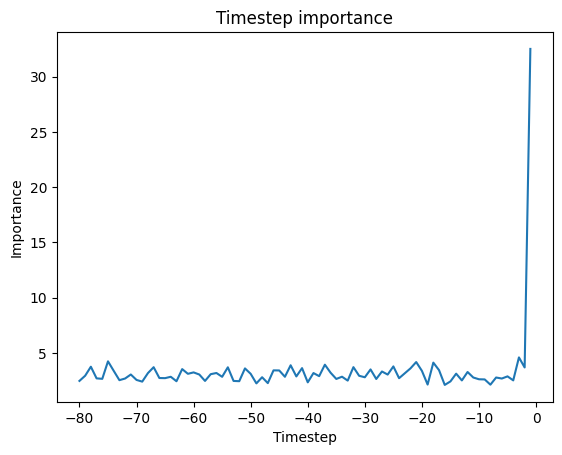

In [28]:
explainer.timestep_importance(data_prediction["src"][0])

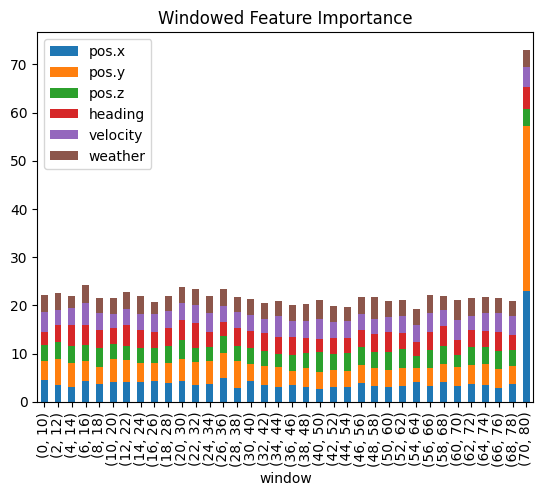

In [29]:
explainer.windowed_feature_importance(data_prediction["src"][0], 10, 2)

In [ ]:
#explainer.feature_importance(data_prediction["src"][0])

In [ ]:
#explainer.output_input_importance(data_prediction["src"][0])